## Module 5 - In this jupyter notebook, target productivity and productivity gaps are calculated
* Step 5a - Set up
* Step 5b - Calculate the target productivity 
* Step 5c - Identify bright spots
* Step 5d - calculate productivity gaps 
**=============================================================================================**
![title](https://github.com/wateraccounting/WAPORWP/blob/master/Notebooks/img/Fig5.PNG?raw=true)
**=============================================================================================**

I will follow the assumption that water input is distributed uniformly over the whole area (although this is not true), but the same calculations can be made if you have data that represent the field more accurately.

## Step 5a - Set up

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## i) Import packages/libraries

In [2]:
import os
import sys
import glob

import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle                # from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.lines as mlines                       # helps to sync colorbar  height with the plot
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable  # helps to sync colorbar height with the plot
from matplotlib import pyplot as plt

# change the directory to where the modules are saved
sys.path.insert(0,'/content/drive/My Drive/WAPORWP/Modules')
from GIS_functions import GIS_function as gis

## Step 5b - Calculate the target productivity 

## i) Define function to plot productivity targets

In [3]:
def plotProductivityTargets (x, y, WP, title1,xlable1,ylable1,title2,xlable2,ylable2): 
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

    ax1.scatter(y,
                WP,
                marker='*',color="grey")

    ax1.scatter(np.nanpercentile(y, 95),
                np.nanpercentile(WP, 95),
                marker='*', color='black', s=100)

    ax1.axvline(np.nanpercentile(y, 95),
                color="#EE6666", linestyle="--")
    
    ax1.axhline(np.nanpercentile(WP, 95),
                color="#EE6666", linestyle="--")    
    
    # ax2 for histogram
    counts, bins, patches = ax2.hist(WP, bins=100, facecolor='skyblue', edgecolor='none', histtype="bar")

    # add legend 
    fakeLine = plt.Line2D([0,0], [0,1], color="#EE6666", linestyle='--')
    fakemark = mlines.Line2D([], [], color='black', marker='*', markersize=10)
    ax2.legend([fakeLine, fakemark], ["95 percentile", 'Productivity target'])

    # Colours for different percentiles of the histogram
    twentyfifth, ninetyfifth = np.nanpercentile(WP, [5, 95])
    for patch, leftside, rightside in zip(patches, bins[:-1], bins[1:]):
        if rightside < twentyfifth:
            patch.set_facecolor('#EE6666')
        elif leftside > ninetyfifth:
            patch.set_facecolor('green')

    # create legend
    handles = [Rectangle((0, 0), 1, 1, color=c, ec="k") for c in ['#EE6666', 'green']]
    labels = ["0-5 Percentile",">95 Percentile"]
    plt.legend(handles, labels)

    # Title  
    ax1.set_title(title1, fontsize=14)
    ax1.set_xlabel(xlable1, fontsize=13)
    ax1.set_ylabel(ylable1, fontsize=13)

    ax2.set_title(title2, fontsize=14)
    ax2.set_xlabel(xlable2, fontsize=13)
    ax2.set_ylabel(ylable2, fontsize=13)

    return None 

## ii) Calculate the target biomass and target biomass water productivity

## * Import the input data (seasonal ${ET_a}$, biomass and WPb raster data)

In [4]:
dir_proj = '/content/drive/My Drive/WAPORWP'
dir_data = "Data"


input_folder1  = os.path.join(dir_proj, dir_data, "field_Water_input")
input_field_water    = sorted(glob.glob(input_folder1 + '/*.npy'))

input_AGBMfolder  = os.path.join(dir_proj, dir_data, "4L2_Biomass") 
input_AGBMfhs     = sorted(glob.glob(input_AGBMfolder + '/*.tif'))

input_WPbfolder   = os.path.join(dir_proj, dir_data, "4L2_WPb") 
input_WPbfhs      = sorted(glob.glob(input_WPbfolder + '/*.tif'))

input_field_water , input_AGBMfhs, input_WPbfhs

(['/content/drive/My Drive/WAPORWP/Data/field_Water_input/season1.npy'],
 ['/content/drive/My Drive/WAPORWP/Data/4L2_Biomass/AGBM_2016-10-01_to_2017-09-30.tif'],
 ['/content/drive/My Drive/WAPORWP/Data/4L2_WPb/WPb_2016-10-01_to_2017-09-30.tif'])

## ** Calculate the target biomass and target biomass WP

In [5]:
# Target productivity
TargetPercentile = 95  

                      Season  Target_biomass  Target_WPb
0   2016-10-01 to 2017-09-30           142.0        10.5


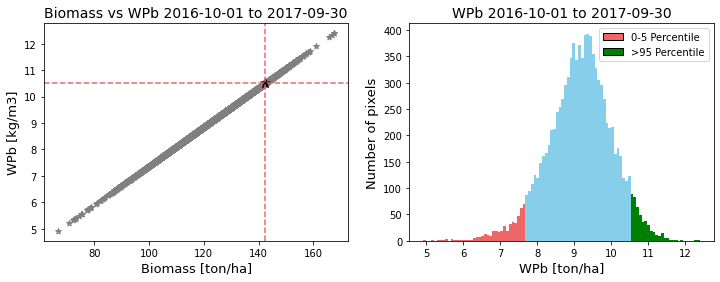

In [6]:
in_fh = input_AGBMfhs[0]      
driver, NDV, xsize, ysize, GeoT, Projection = gis.GetGeoInfo(in_fh)
spatial_extent = (GeoT[0], GeoT[0] + GeoT[1] * xsize, GeoT[3] + GeoT[5] * ysize, GeoT[3])  # get spatial extent of raster

Season        = []
BiomassTarget = []
WPbTarget     = []

for in_fw, in_fhAGBM, in_fhWPb in zip(input_field_water, input_AGBMfhs, input_WPbfhs): 
    # AETI   = gis.OpenAsArray(in_fhET, nan_values=True)
    fw     = np.load(in_fw) 
    AGBM   = gis.OpenAsArray(in_fhAGBM,  nan_values=True) 
    WPb    = gis.OpenAsArray(in_fhWPb, nan_values=True)
    
    # reshape the arrays
    AETI_1D    = np.reshape(fw, fw.shape[0]*fw.shape[1])
    Biomass_1D = np.reshape(AGBM, AGBM.shape[0] * AGBM.shape[1])
    WPb_1D     = np.reshape(WPb, WPb.shape[0] * WPb.shape[1])
    
    # targets productivity
    Target_biomass = round(np.nanpercentile(Biomass_1D, TargetPercentile), 0)  # Yield at 95 percentile
    TargetWP       = round(np.nanpercentile(WPb_1D, TargetPercentile), 1)         # WP at 95 percentile
    
    # Identify the date and season from the file name
    date  = os.path.basename(in_fhAGBM).split('.')[0].replace('AGBM', '').replace('_', ' ')
    
    Season.append(date)
    BiomassTarget.append(Target_biomass)
    WPbTarget.append(TargetWP)
    
    # scatter plot of Yield vs WP and histogram of WP for 2017
    year = int(date.split (' ')[1].split('-')[0])
    
    title1  = 'Biomass vs WPb'+date
    xlable1 = 'Biomass [ton/ha]'
    ylable1 = 'WPb [kg/m3]'
    
    title2  = 'WPb'+date
    xlable2 = 'WPb [ton/ha]'
    ylable2 = 'Number of pixels'
    
    title1,xlable1,ylable1
    plotProductivityTargets(AETI_1D,  Biomass_1D, WPb_1D, title1,xlable1,ylable1, title2,xlable2,ylable2)

# save the data into dataframe - tabular form
data_tuples = list(zip(Season, BiomassTarget, WPbTarget))
df_targets = pd.DataFrame(data_tuples, columns=['Season', 'Target_biomass', 'Target_WPb'])
print(df_targets);

## iii) Calculate the target crop yield and target crop water productivity

## * Import the input data (seasonal ${ET_a}$, crop yield and WPc raster data)

In [7]:
dir_proj = '/content/drive/My Drive/WAPORWP'
dir_data = "Data"

input_folder1  = os.path.join(dir_proj, dir_data, "field_Water_input")
input_field_water    = sorted(glob.glob(input_folder1 + '/*.npy'))

input_Yieldfolder  = os.path.join(dir_proj, dir_data, "4L2_Yield") 
input_Yieldfhs     = sorted(glob.glob(input_Yieldfolder + '/*.tif'))

input_WPyfolder   = os.path.join(dir_proj, dir_data, "4L2_WPy") 
input_WPyfhs      = sorted(glob.glob(input_WPyfolder + '/*.tif'))

input_field_water  , input_Yieldfhs, input_WPyfhs

(['/content/drive/My Drive/WAPORWP/Data/field_Water_input/season1.npy'],
 ['/content/drive/My Drive/WAPORWP/Data/4L2_Yield/Yield_2016-10-01_to_2017-09-30.tif'],
 ['/content/drive/My Drive/WAPORWP/Data/4L2_WPy/WPy_2016-10-01_to_2017-09-30.tif'])

## ** Calculate the target crop yield and target crop WP

In [8]:
# Target productivity
TargetPercentile = 95  

                      Season  Target_yield  Target_WPy
0   2016-10-01 to 2017-09-30         142.0        10.5


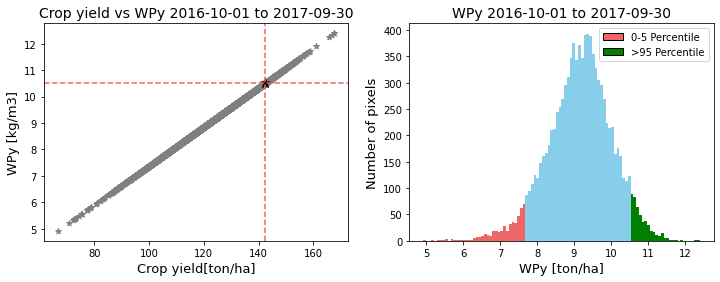

In [9]:
in_fh = input_Yieldfhs[0]      
driver, NDV, xsize, ysize, GeoT, Projection = gis.GetGeoInfo(in_fh)
spatial_extent = (GeoT[0], GeoT[0] + GeoT[1] * xsize, GeoT[3] + GeoT[5] * ysize, GeoT[3])  # get spatial extent of raster

Season        = []
YieldTarget   = []
WPyTarget     = []

for in_fw, in_fhYield, in_fhWPy in zip(input_field_water, input_Yieldfhs, input_WPyfhs): 
    # AETI   = gis.OpenAsArray(in_fhET, nan_values=True) 
    fw      = np.load(in_fw)
    Yield  = gis.OpenAsArray(in_fhYield,  nan_values=True) 
    WPy    = gis.OpenAsArray(in_fhWPy, nan_values=True)
    
    # reshape the arrays
    AETI_1D    = np.reshape(fw, fw.shape[0]*fw.shape[1])
    Yield_1D   = np.reshape(Yield, Yield.shape[0] * Yield.shape[1])
    WPy_1D     = np.reshape(WPy, WPy.shape[0] * WPy.shape[1])
    
    # targets productivity
    Target_yield   = round(np.nanpercentile(Yield_1D, TargetPercentile), 0)  # Yield at 95 percentile
    TargetWP       = round(np.nanpercentile(WPy_1D, TargetPercentile), 1)         # WP at 95 percentile
    
    # Identify the date and season from the file name
    date  = os.path.basename(in_fhYield).split('.')[0].replace('Yield', '').replace('_', ' ')
    
    Season.append(date)
    YieldTarget.append(Target_yield)
    WPyTarget.append(TargetWP )
    
    # scatter plot of Yield vs WP and histogram of WP for 2017
    year = int(date.split (' ')[1].split('-')[0])
    
    title1  = 'Crop yield vs WPy'+date
    xlable1 = 'Crop yield[ton/ha]'
    ylable1 = 'WPy [kg/m3]'
    
    title2  = 'WPy'+date
    xlable2 = 'WPy [ton/ha]'
    ylable2 = 'Number of pixels'
    
    title1,xlable1,ylable1
    plotProductivityTargets(AETI_1D,  Yield_1D, WPy_1D, title1,xlable1,ylable1, title2,xlable2,ylable2)
        
    year += 1

# save the data into dataframe - tabular form
data_tuples = list(zip(Season, YieldTarget, WPyTarget))
df_targets = pd.DataFrame(data_tuples, columns=['Season', 'Target_yield', 'Target_WPy'])
print(df_targets);

## Step 5c - Identify bright spots 
* The bright spots are idetified based on the target biomass and target biomass water productivity (WPb)

## i) Import the input data (seasonal ${ET_a}$, biomass and WPb raster data)

In [10]:
dir_proj = '/content/drive/My Drive/WAPORWP'
dir_data = "Data"

input_ETfolder    = os.path.join(dir_proj, dir_data, "2L2_AETI_season") 
input_ETfhs       = sorted(glob.glob(input_ETfolder + '/*.tif'))

input_AGBMfolder  = os.path.join(dir_proj, dir_data, "4L2_Biomass") 
input_AGBMfhs     = sorted(glob.glob(input_AGBMfolder + '/*.tif'))

input_WPbfolder   = os.path.join(dir_proj, dir_data, "4L2_WPb") 
input_WPbfhs      = sorted(glob.glob(input_WPbfolder + '/*.tif'))

input_ETfhs , input_AGBMfhs, input_WPbfhs

(['/content/drive/My Drive/WAPORWP/Data/2L2_AETI_season/ETa_2016-10-01_to_2017-09-30.tif'],
 ['/content/drive/My Drive/WAPORWP/Data/4L2_Biomass/AGBM_2016-10-01_to_2017-09-30.tif'],
 ['/content/drive/My Drive/WAPORWP/Data/4L2_WPb/WPb_2016-10-01_to_2017-09-30.tif'])

## ii) Map the bright spots in the study area

In [11]:
# Target productivity
TargetPercentile = 95  

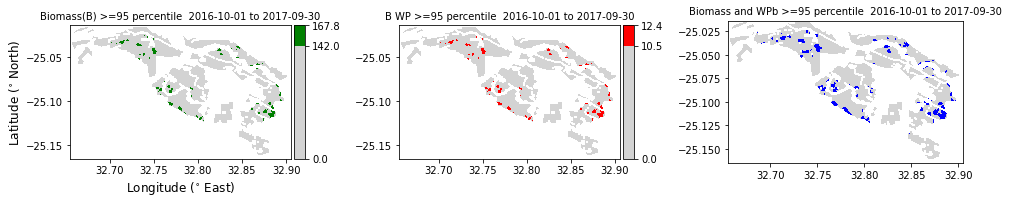

In [12]:
in_fh = input_ETfhs[0]      
driver, NDV, xsize, ysize, GeoT, Projection = gis.GetGeoInfo(in_fh)
spatial_extent = (GeoT[0], GeoT[0] + GeoT[1] * xsize, GeoT[3] + GeoT[5] * ysize, GeoT[3])  # get spatial extent of raster

for in_fhET, in_fhAGBM, in_fhWPb in zip(input_ETfhs, input_AGBMfhs, input_WPbfhs): 
    AETI   = gis.OpenAsArray(in_fhET, nan_values=True) 
    AGBM   = gis.OpenAsArray(in_fhAGBM,  nan_values=True) 
    WPb    = gis.OpenAsArray(in_fhWPb, nan_values=True)
    
    # reshape the arrays
    AETI_1D    = np.reshape(AETI, AETI.shape[0]*AETI.shape[1])
    Biomass_1D = np.reshape(AGBM, AGBM.shape[0] * AGBM.shape[1])
    WPb_1D     = np.reshape(WPb, WPb.shape[0] * WPb.shape[1])
    
    # save the data into dataframe - tabular form
    data_tuples = list(zip(AETI_1D,Biomass_1D,WPb_1D))
    df          = pd.DataFrame(data_tuples, columns=['ETa','Biomass','WP'])
    
    # thresholds for the targets
    TargetBiomass = round(np.nanpercentile(Biomass_1D, TargetPercentile), 0)
    TargetWP      = round(np.nanpercentile(WPb_1D , TargetPercentile), 1)
    maxBiomass    = round(df["Biomass"].max(),1)
    maxWPb        = round(df["WP"].max(),1)
    
# Identify the date and season from the file name
    date  = os.path.basename(in_fhET).split('.')[0].replace('ETa', '').replace('_', ' ')
    
    ## Plot
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(16, 8))
    
    # ax1, plot raster map, highlight Yield greater than or equal to the target
    cmap1   = colors.ListedColormap(['lightgrey', 'green'])
    bounds1 = [0, TargetBiomass, maxBiomass]
    norm1   = colors.BoundaryNorm(bounds1, cmap1.N)
    
    img1     = ax1.imshow(AGBM, cmap=cmap1, norm=norm1, extent=spatial_extent)
    divider1 = make_axes_locatable(ax1)
    cax1     = divider1.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(img1, spacing='proportional', ax=ax1, cax=cax1)
    ax1.set_title ('Biomass(B) >='+str(TargetPercentile)+ ' percentile ' + date, fontsize=10)
    
    ### add axes label
    ax1.set_xlabel('Longitude ($^{\circ}$ East)', fontsize=12)  # add axes label
    ax1.set_ylabel('Latitude ($^{\circ}$ North)', fontsize=12)
    
    # ax2, plot raster map, highlight Yield greater than or equal to the target 
    cmap2   = colors.ListedColormap(['lightgrey', 'red'])
    bounds2 = [0, TargetWP, maxWPb]
    norm2   = colors.BoundaryNorm(bounds2, cmap2.N)
 
    img2     = ax2.imshow(WPb, cmap=cmap2, norm=norm2, extent=spatial_extent)
    divider2 = make_axes_locatable(ax2)
    cax2     = divider2.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(img2, spacing='proportional', ax=ax2, cax=cax2)
    ax2.set_title ('B WP >='+str(TargetPercentile)+ ' percentile ' + date, fontsize=10)  
    
    # ax3, plot raster map, highlight when both Yield and WP greater than or equal to the targets
    Biomass_targeSpots      = np.where(((AGBM >= TargetBiomass ) & (WPb >= TargetWP)), AGBM, np.nan)
    Biomass_WPb_targetSpots = np.where((AGBM  < TargetBiomass), 1, Biomass_targeSpots)

    cmap3   = colors.ListedColormap(['lightgrey', 'blue'])
    bounds3 = [0, TargetWP, maxWPb]
    norm3   = colors.BoundaryNorm(bounds3, cmap3.N)
 
    img3 = ax3.imshow(Biomass_WPb_targetSpots, cmap=cmap3, norm=norm3, extent=spatial_extent)
    # fig.colorbar(img3, spacing='proportional', ax=ax3)
    ax3.set_title ('Biomass and WPb >='+str(TargetPercentile)+ ' percentile ' + date, fontsize=10)  
    
    plt.subplots_adjust(wspace=0.4)
    
    plt.show()
    ;

## Step 5d - Calculate productivity gaps
* i) Biomass gaps and biomass WP gaps
* ii)Crop yield gaps and crop WP gaps

## i) Biomass gaps and biomass water productivity gaps

## * Import the input data (biomass and WPb raster data)

In [13]:
dir_proj = '/content/drive/My Drive/WAPORWP'
dir_data = "Data"

input_AGBMfolder  = os.path.join(dir_proj, dir_data, "4L2_Biomass") 
input_AGBMfhs     = sorted(glob.glob(input_AGBMfolder + '/*.tif'))

input_WPbfolder   = os.path.join(dir_proj, dir_data, "4L2_WPb") 
input_WPbfhs      = sorted(glob.glob(input_WPbfolder + '/*.tif'))

input_AGBMfhs, input_WPbfhs

(['/content/drive/My Drive/WAPORWP/Data/4L2_Biomass/AGBM_2016-10-01_to_2017-09-30.tif'],
 ['/content/drive/My Drive/WAPORWP/Data/4L2_WPb/WPb_2016-10-01_to_2017-09-30.tif'])

## * Output folder: Make one or connect to the existing one

In [14]:
dir_proj = '/content/drive/My Drive/WAPORWP'
dir_data = "Data"

output_folder1 = os.path.join(dir_proj, dir_data, "5L2_BiomassGaps") 
output_folder2 = os.path.join(dir_proj, dir_data, "5L2_WPbgaps") 

# if the directory and folder does not exit, make one
if not os.path.exists(output_folder1):
    os.makedirs(output_folder1) 
if not os.path.exists(output_folder2):
    os.makedirs(output_folder2)

output_folder1, output_folder2

('/content/drive/My Drive/WAPORWP/Data/5L2_BiomassGaps',
 '/content/drive/My Drive/WAPORWP/Data/5L2_WPbgaps')

## ** Biomass gaps

In [15]:
# Target productivity
TargetPercentile = 95  

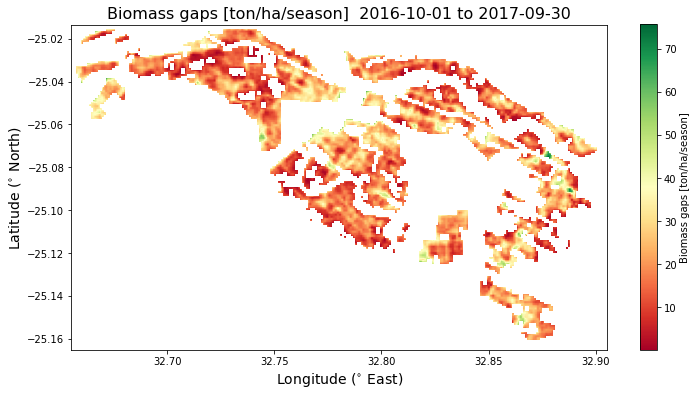

In [16]:
in_fh = input_AGBMfhs[0]      
driver, NDV, xsize, ysize, GeoT, Projection = gis.GetGeoInfo(in_fh)
spatial_extent = (GeoT[0], GeoT[0] + GeoT[1] * xsize, GeoT[3] + GeoT[5] * ysize, GeoT[3])  # get spatial extent of raster

for in_fhAGBM in input_AGBMfhs: 
    AGBM = gis.OpenAsArray(in_fhAGBM, nan_values=True) 
    
    # productivity targets and produtivity gaps
    Biomass_1D = np.reshape(AGBM, AGBM.shape[0] * AGBM.shape[1])  # reshape the arrays
    TargetBiomass = round(np.nanpercentile(Biomass_1D, TargetPercentile), 1)
    Biomassgap = np.where( AGBM < TargetBiomass, TargetBiomass - AGBM, np.nan)
    
    # Identify the date from the file name
    date  = os.path.basename(in_fhAGBM).split('.')[0].replace('AGBM', '').replace('_', ' ')
    
    # save yield gap
    output_folder = output_folder1
    basename      = os.path.basename(in_fhAGBM).replace('AGBM','BiomassGaps')
    output_fn     = os.path.join(output_folder, basename)
    gis.CreateGeoTiff(output_fn, Biomassgap, driver, NDV, xsize, ysize, GeoT, Projection) 
    
    # Plot the raster map
    seasonal = Biomassgap
    
    plt.figure(figsize = (12,8))
    plt.imshow(seasonal, cmap='RdYlGn', vmin=np.nanmin(seasonal), vmax=np.nanmax(seasonal), extent=spatial_extent)
    plt.colorbar(shrink=0.75, label ='Biomass gaps [ton/ha/season]')
    plt.xlabel('Longitude ($^{\circ}$ East)', fontsize=14)  # add axes label
    plt.ylabel('Latitude ($^{\circ}$ North)', fontsize=14)
    plt.title('Biomass gaps [ton/ha/season] ' + date, fontsize=16)
    plt.show () 
    ;

## *** Biomass WP gaps (WPb gaps)

In [17]:
# Target productivity
TargetPercentile = 95  

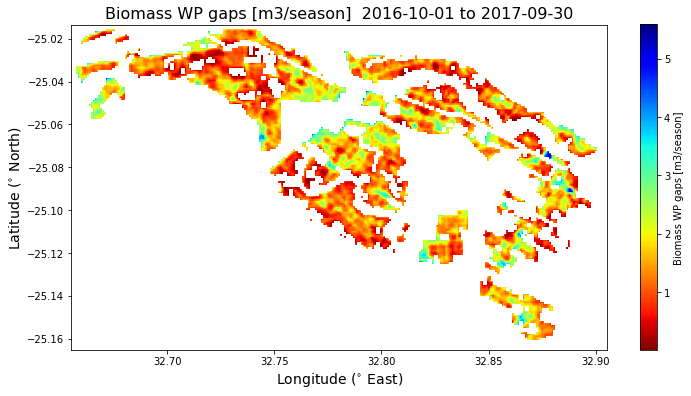

In [18]:
in_fh = input_WPbfhs[0]      
driver, NDV, xsize, ysize, GeoT, Projection = gis.GetGeoInfo(in_fh)
spatial_extent = (GeoT[0], GeoT[0] + GeoT[1] * xsize, GeoT[3] + GeoT[5] * ysize, GeoT[3])  # get spatial extent of raster

for in_fhWPb in input_WPbfhs: 
    WPb = gis.OpenAsArray(in_fhWPb, nan_values=True) 
    
    # productivity targets and produtivity gaps
    WPb_1D     = np.reshape(WPb, WPb.shape[0] * WPb.shape[1])  # reshape the arrays
    TargetWPb  = round(np.nanpercentile(WPb_1D, TargetPercentile), 2)
    WPbgap     = np.where( WPb < TargetWPb, TargetWPb - WPb, np.nan)
    
    # Identify the date from the file name
    date  = os.path.basename(in_fhWPb).split('.')[0].replace('WPb', '').replace('_', ' ')
    
    # save yield gap
    output_folder = output_folder2
    basename      = os.path.basename(in_fhWPb).replace('WPb','WPbGaps')
    output_fn     = os.path.join(output_folder, basename)
    gis.CreateGeoTiff(output_fn,  WPbgap, driver, NDV, xsize, ysize, GeoT, Projection) 
    
    # Plot the raster map
    seasonal =  WPbgap
    
    plt.figure(figsize = (12,8))
    plt.imshow(seasonal, cmap='jet_r', vmin=np.nanmin(seasonal), vmax=np.nanmax(seasonal), extent=spatial_extent)
    plt.colorbar(shrink=0.75, label = 'Biomass WP gaps [m3/season]')
    plt.xlabel('Longitude ($^{\circ}$ East)', fontsize=14)  # add axes label
    plt.ylabel('Latitude ($^{\circ}$ North)', fontsize=14)
    plt.title('Biomass WP gaps [m3/season] ' + date, fontsize= 16)
    plt.show () 
    ;

## ii) Crop yield gaps and crop water productivity gaps

## * Import the input data (biomass and WPb raster data)

In [19]:
dir_proj = '/content/drive/My Drive/WAPORWP'
dir_data = "Data"

input_AGBMfolder  = os.path.join(dir_proj, dir_data, "4L2_Yield") 
input_Yieldfhs     = sorted(glob.glob(input_AGBMfolder + '/*.tif'))

input_WPyfolder   = os.path.join(dir_proj, dir_data, "4L2_WPy") 
input_WPyfhs      = sorted(glob.glob(input_WPyfolder + '/*.tif'))

input_Yieldfhs, input_WPbfhs

(['/content/drive/My Drive/WAPORWP/Data/4L2_Yield/Yield_2016-10-01_to_2017-09-30.tif'],
 ['/content/drive/My Drive/WAPORWP/Data/4L2_WPb/WPb_2016-10-01_to_2017-09-30.tif'])

## ** Output folder: Make one or connect to the existing one

In [20]:
dir_proj = '/content/drive/My Drive/WAPORWP'
dir_data = "Data"

output_folder1 = os.path.join(dir_proj, dir_data, "5L2_YieldGaps") 
output_folder2 = os.path.join(dir_proj, dir_data, "5L2_WPygaps") 

# if the directory and folder does not exit, make one
if not os.path.exists(output_folder1):
    os.makedirs(output_folder1) 
if not os.path.exists(output_folder2):
    os.makedirs(output_folder2)

output_folder1, output_folder2

('/content/drive/My Drive/WAPORWP/Data/5L2_YieldGaps',
 '/content/drive/My Drive/WAPORWP/Data/5L2_WPygaps')

## ** Crop yield gaps

In [21]:
# Target productivity
TargetPercentile = 95  

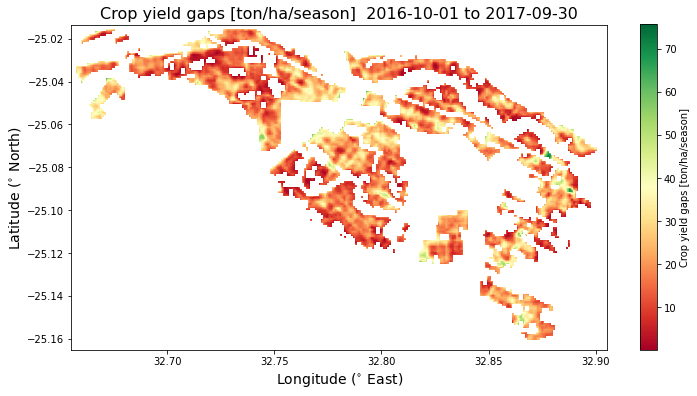

In [22]:
in_fh = input_Yieldfhs [0]      
driver, NDV, xsize, ysize, GeoT, Projection = gis.GetGeoInfo(in_fh)
spatial_extent = (GeoT[0], GeoT[0] + GeoT[1] * xsize, GeoT[3] + GeoT[5] * ysize, GeoT[3])  # get spatial extent of raster

for in_fhAYield in input_Yieldfhs : 
    Yield = gis.OpenAsArray(in_fhAYield, nan_values=True) 
    
    # productivity targets and produtivity gaps
    Yield_1D    = np.reshape(Yield, Yield.shape[0] * Yield.shape[1])  # reshape the arrays
    TargetYield = round(np.nanpercentile(Yield_1D, TargetPercentile), 1)
    Yieldgap    = np.where( Yield < TargetYield, TargetYield - Yield, np.nan)
    
    # Identify the date from the file name
    date  = os.path.basename(in_fhAYield).split('.')[0].replace('Yield', '').replace('_', ' ')
    
    # save yield gap
    output_folder = output_folder1
    basename      = os.path.basename(in_fhAYield).replace('Yield','YieldGaps')
    output_fn     = os.path.join(output_folder, basename)
    gis.CreateGeoTiff(output_fn, Yieldgap, driver, NDV, xsize, ysize, GeoT, Projection) 
    
    # Plot the raster map
    seasonal = Yieldgap
    
    plt.figure(figsize = (12,8))
    plt.imshow(seasonal, cmap='RdYlGn', vmin=np.nanmin(seasonal), vmax=np.nanmax(seasonal), extent=spatial_extent)
    plt.colorbar(shrink=0.75, label ='Crop yield gaps [ton/ha/season]')
    plt.xlabel('Longitude ($^{\circ}$ East)', fontsize=14)  # add axes label
    plt.ylabel('Latitude ($^{\circ}$ North)', fontsize=14)
    plt.title('Crop yield gaps [ton/ha/season] ' + date, fontsize=16)
    plt.show () 
    ;

## *** Crop WP gaps

In [23]:
# Target productivity
TargetPercentile = 95  

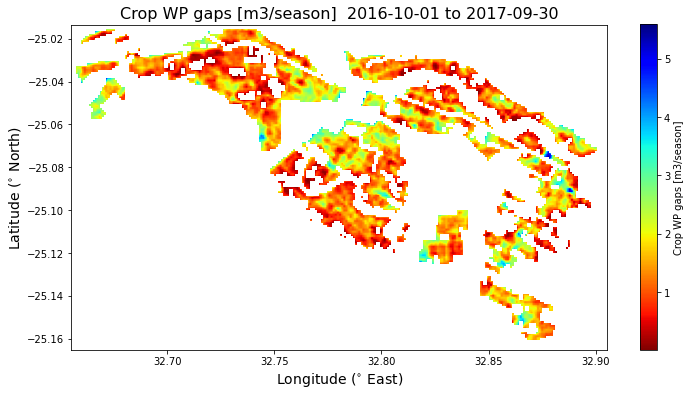

In [24]:
in_fh = input_WPyfhs[0]      
driver, NDV, xsize, ysize, GeoT, Projection = gis.GetGeoInfo(in_fh)
spatial_extent = (GeoT[0], GeoT[0] + GeoT[1] * xsize, GeoT[3] + GeoT[5] * ysize, GeoT[3])  # get spatial extent of raster

for in_fhWPy in input_WPyfhs: 
    WPy = gis.OpenAsArray(in_fhWPy, nan_values=True) 
    
    # productivity targets and produtivity gaps
    WPy_1D     = np.reshape(WPy, WPy.shape[0] * WPy.shape[1])  # reshape the arrays
    TargetWPy  = round(np.nanpercentile(WPy_1D, TargetPercentile), 2)
    WPygap     = np.where( WPy < TargetWPy, TargetWPy - WPy, np.nan)
    
    # Identify the date from the file name
    date  = os.path.basename(in_fhWPy).split('.')[0].replace('WPy', '').replace('_', ' ')
    
    # save yield gap
    output_folder = output_folder2
    basename      = os.path.basename(in_fhWPy).replace('WPy','WPyGaps')
    output_fn     = os.path.join(output_folder, basename)
    gis.CreateGeoTiff(output_fn,  WPbgap, driver, NDV, xsize, ysize, GeoT, Projection) 
    
    # Plot the raster map
    seasonal =  WPygap
    
    plt.figure(figsize = (12,8))
    plt.imshow(seasonal, cmap='jet_r', vmin=np.nanmin(seasonal), vmax=np.nanmax(seasonal), extent=spatial_extent)
    plt.colorbar(shrink=0.75, label = 'Crop WP gaps [m3/season]')
    plt.xlabel('Longitude ($^{\circ}$ East)', fontsize=14)  # add axes label
    plt.ylabel('Latitude ($^{\circ}$ North)', fontsize=14)
    plt.title('Crop WP gaps [m3/season] ' + date, fontsize= 16)
    plt.show () 
    